In [1]:
import sys
# sys.path.append('./keras-spp/')
# from spp.SpatialPyramidPooling import SpatialPyramidPooling

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import glob
import os
from scipy.misc import imread, imresize
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray
from keras.utils import np_utils
import pywt
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize


Using TensorFlow backend.


#### Load Data

In [2]:
master_folder = '../../Desktop/PhotosDataset'

imgs = []
labels = []
for photo in os.listdir(master_folder+'/Alex'):
    img = imread(master_folder+'/Alex/'+photo)
    imgs.append(resize(img,(200,200,3)))
    labels.append('Alex')
for photo in os.listdir(master_folder+'/Hunter'):
    img = imread(master_folder+'/Hunter/'+photo)
    imgs.append(resize(img,(200,200,3)))
    labels.append('Hunter')

og_labels = labels.copy()
labels = np.array([[1,0] if label is 'Hunter' else [0,1] for label in labels])



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


#### Massage Data

In [4]:
# Take out alpha component of image
#imgs = [img[:,:,[0,1,2]] for img in imgs]

wavelet_imgs = []
for i, img in enumerate(imgs):
    
    if i % 50 == 0:
        print(i)
    coeffs2 = pywt.dwt2(img, 'bior1.3')
    
    wavelet_imgs.append(coeffs2[1][:2])

for i,stack in enumerate(wavelet_imgs):
    stack = np.dstack(stack)
    #print(stack)
    wavelet_imgs[i] = stack[:,:,:3]
print(wavelet_imgs[0].shape)

x_train, x_test, y_train, y_test = train_test_split(wavelet_imgs, labels, test_size=.2)
x_train = np.stack(x_train,axis=0)
x_test = np.stack(x_test,axis=0)

num_classes = 2
# y_train = np_utils.to_categorical(y_train, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)

x_train.shape

0
50
100
150
200
250
300
350
(200, 102, 3)


(295, 200, 102, 3)

In [6]:
# # Use a generator to feed data because data images are of different dimensions so a numpy array cant
# # be constructed
# def generator(x, y):
#     while True:
#         for i,img in enumerate(x):
#             yield np.expand_dims(img,axis=0), np.expand_dims(y[i],axis=0)
            

            
# gen = generator(x_train, y_train)
# val_gen = generator(x_test,y_test)
num_channels = 3
# num_classes = 2
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)
# gen = generator(x_train, y_train)

# val_gen = generator(x_test,y_test)
batch_size=4
epochs=10


In [7]:
#print(y_train)

### Model with no transfer learning

In [8]:
model = Sequential()

# Note that we leave the image size as None to allow multiple image sizes
model.add(Conv2D(96, (7, 7),strides=2, padding='same',
                 activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]),
                name='input_layer'))
model.add(MaxPooling2D((3,3)))

model.add(Conv2D(48, (5, 5),strides=1, padding='same',activation='sigmoid'))
model.add(MaxPooling2D((3,3)))

model.add(Conv2D(24, (3, 3),strides=1, padding='same',activation='sigmoid'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(24, (3, 3),strides=1, padding='same',activation='sigmoid'))
model.add(Flatten())
# # Spatial Pooling layer to deal with differing image sizes
#model.add(SpatialPyramidPooling([6, 3, 2,1]))
model.add(Dense(512,activation = 'sigmoid'))
model.add(Dense(128,activation='sigmoid'))

# Classification layer
model.add(Dense(2, activation='softmax'))

callbacks = []
callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=15, verbose=1, mode='auto',
                                   min_delta=0.0001, cooldown=0, min_lr=0))
# opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# hist = model.fit_generator(datagen.flow(x_train, y_train,
#                                  batch_size=batch_size),
#                     steps_per_epoch=x_train.shape[0] // batch_size,
#                     epochs=epochs,
#                     validation_data=(x_test, y_test),verbose=1,
#                     callbacks=callbacks)

model.fit(x_train,y_train, batch_size = batch_size, epochs = epochs)


W1211 10:46:15.933187 140734816122304 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1211 10:46:16.022058 140734816122304 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
295/295 [==============================] - 4s 13ms/step - loss: 0.7266 - acc: 0.4814
Epoch 2/10
295/295 [==============================] - 3s 11ms/step - loss: 0.1261 - acc: 0.9797
Epoch 3/10
295/295 [==============================] - 3s 12ms/step - loss: 0.0163 - acc: 0.9966
Epoch 4/10
295/295 [==============================] - 4s 13ms/step - loss: 0.0022 - acc: 1.0000
Epoch 5/10
295/295 [==============================] - 4s 12ms/step - loss: 0.0016 - acc: 1.0000
Epoch 6/10
295/295 [==============================] - 3s 12ms/step - loss: 0.0012 - acc: 1.0000
Epoch 7/10
295/295 [==============================] - 3s 12ms/step - loss: 9.5555e-04 - acc: 1.0000
Epoch 8/10
295/295 [==============================] - 4s 13ms/step - loss: 7.8721e-04 - acc: 1.0000
Epoch 9/10
295/295 [==============================] - 4s 14ms/step - loss: 6.6339e-04 - acc: 1.0000
Epoch 10/10
295/295 [==============================] - 4s 13ms/step - loss: 5.6927e-04 - acc: 1.0000


### Utilize transfer learning

In [21]:
filepath = "wavelet_model-3-channel.h5"
trans_model = load_model(filepath)
#print(trans_model.summary())
# Allow no weight adjustments for the pretrained layers
for layer in trans_model.layers:
    layer.trainable = False

trans_model.add(Conv2D(32,(2,2)))
trans_model.add(MaxPooling2D((2,2)))
trans_model.add(Flatten())
trans_model.add(Dense(128,activation='sigmoid'))
trans_model.add(Dropout(0.3))

trans_model.add(Dense(32, activation = 'sigmoid'))
trans_model.add(Dropout(0.3))
# Classification Layer
trans_model.add(Dense(num_classes, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [23]:
callbacks = []
callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=15, verbose=1, mode='auto',
                                   min_delta=0.0001, cooldown=0, min_lr=0))
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
trans_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


epochs = 1
# Fit model
trans_hist = trans_model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),verbose=1,
                    callbacks=callbacks)

#trans_model.fit(x_train,y_train, batch_size = batch_size, epochs =6)

Epoch 1/1
73/73 [==============================] - 8s 105ms/step - loss: 0.1586 - acc: 0.9623 - val_loss: 0.0731 - val_acc: 0.9730


Evaluate

In [11]:
trans_pred = []
reg_pred= []

for img in x_test:
    trans_pred.append(trans_model.predict(np.expand_dims(img, axis=0)))
    reg_pred.append(model.predict(np.expand_dims(img, axis=0)))

#print(y_test)
reg_pred = ["Hunter" if x[0][0] > x[0][1] else "Alex" for x in reg_pred]
trans_pred = ["Hunter" if x[0][0] > x[0][1] else "Alex" for x in trans_pred]

y_test_lab = ["Hunter" if x[0] > x[1] else "Alex" for x in y_test]

# print(reg_pred)
print(trans_pred)
print(y_test_lab)

['Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Alex', 'Hunter', 'Alex', 'Alex', 'Alex', 'Hunter', 'Alex', 'Alex', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Alex', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Alex']
['Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Alex', 'Hunter', 'Alex', 'Alex', 'Alex', 'Hunter', 'Alex', 'Alex', 'Alex', 'Alex', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Hunter', 'Alex', 'Hunter', 'Hun

In [12]:
from sklearn.metrics import classification_report
print("Model with No transfer learning")
print(classification_report(y_test_lab, reg_pred))
print("Model with transfer learning")
print(classification_report(y_test_lab, trans_pred))

Model with No transfer learning
              precision    recall  f1-score   support

        Alex       1.00      1.00      1.00        31
      Hunter       1.00      1.00      1.00        43

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74

Model with transfer learning
              precision    recall  f1-score   support

        Alex       0.97      1.00      0.98        31
      Hunter       1.00      0.98      0.99        43

    accuracy                           0.99        74
   macro avg       0.98      0.99      0.99        74
weighted avg       0.99      0.99      0.99        74



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


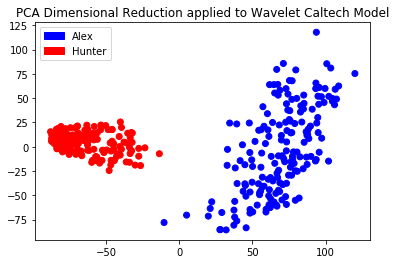

In [13]:
t_model = load_model(filepath)
wavestack = np.stack(wavelet_imgs,axis = 0)
trans_imgs = t_model.predict(wavestack)

trans_imgs = trans_imgs.reshape(369,-1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_trans_imgs = pca.fit_transform(trans_imgs)

import matplotlib.patches as mpatches
alex = mpatches.Patch(color='blue', label='Alex')
hunter = mpatches.Patch(color='red', label='Hunter')

a = plt.scatter(pca_trans_imgs[:,0],pca_trans_imgs[:,1],
            c=['red' if label=='Hunter' else 'blue' for label in og_labels])

plt.legend(handles=[alex,hunter])
plt.title('PCA Dimensional Reduction applied to Wavelet Caltech Model')
plt.savefig('Caltech_dimension_reduction-Wavelet Transform')

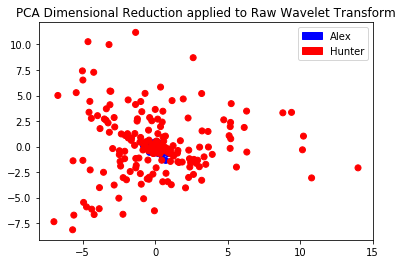

In [24]:
wavestack = np.stack(wavelet_imgs,axis = 0)
trans_imgs = wavestack.reshape(369,-1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_trans_imgs = pca.fit_transform(trans_imgs)

import matplotlib.patches as mpatches
alex = mpatches.Patch(color='blue', label='Alex')
hunter = mpatches.Patch(color='red', label='Hunter')

a = plt.scatter(pca_trans_imgs[:,0],pca_trans_imgs[:,1],
            c=['red' if label=='Hunter' else 'blue' for label in og_labels])

plt.legend(handles=[alex,hunter])
plt.title('PCA Dimensional Reduction applied to Raw Wavelet Transform')
plt.savefig('wavelet_dimension_reduction')